In [ ]:
import os

imdb_dir = "aclImdb/aclImdb"
train_dir = os.path.join(imdb_dir, "train")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname [-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)                    
                

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing. sequence import pad_sequences
import numpy as np

maxlen = 100 # cuts off review after 100 words
training_samples = 200 # Trains on 200 samples
validation_samples = 10000 # Validates o 10000 samples
max_words = 10000 # Considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index 
print("Found %s unique tokens." % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

indices = np.arange(data.shape[0]) # Splits data into training and validation set, but shuffles is, since samples are ordered: 
# all negatives first, then all positive
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples] # (200, 100)
y_train = labels[:training_samples] # shape (200,)
x_val = data[training_samples:training_samples+validation_samples] # shape (10000, 100)
y_val = labels[training_samples:training_samples+validation_samples] # shape (10000,)

Using TensorFlow backend.


Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


In [ ]:
glove_dir = "glove.6B"
embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"), encoding='utf-8') #added , encoding='utf-8'
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("found %s word vectors." % len (embeddings_index))

found 400000 word vectors.


In [ ]:
embedding_dim = 100 # GloVe contains 100-dimensional embedding vectors for 400.000 words

embedding_matrix = np.zeros((max_words, embedding_dim)) # embedding_matrix.shape (10000, 100)
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) # embedding_vector.shape (100,)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the mebedding index will all be zeros

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen)) 
model.add(Flatten()) 
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation="sigmoid")) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False 

In [ ]:
model.compile(optimizer = "rmsprop", 
              loss = "binary_crossentropy", # in a multiclass problem categorical_crossentropy would be used
              metrics = ["acc"]) 
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (x_val, y_val))
model.save_weights("pre_trained_glove_model.h5")   

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.3355 - acc: 0.4650 - val_loss: 0.6910 - val_acc: 0.7264
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6054 - acc: 0.7000 - val_loss: 1.2312 - val_acc: 0.7264
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5582 - acc: 0.7000 - val_loss: 0.7117 - val_acc: 0.7264
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5122 - acc: 0.7350 - val_loss: 0.9140 - val_acc: 0.3429
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5370 - acc: 0.7900 - val_loss: 0.6630 - val_acc: 0.7256
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1307 - acc: 0.9800 - val_loss: 1.0282 - val_acc: 0.7264
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2247 - acc: 0.9050 - val_loss: 0.6604 - val_acc: 0.6534
Epoch 8/10
200/200 [========

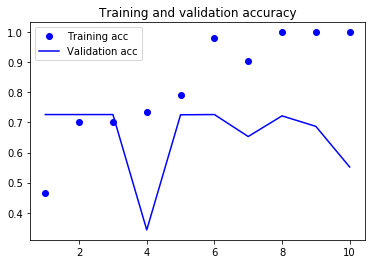

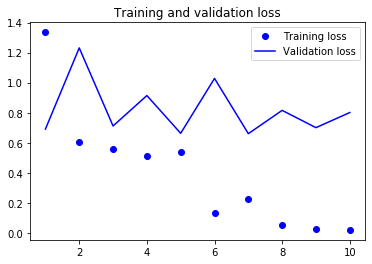

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["acc"] # Training accuracy
val_acc = history.history["val_acc"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

epochs = range(1, len(acc) + 1) #plots every epoch, here 10

plt.plot(epochs, acc, "bo", label = "Training acc") # "bo" gives dot plot
plt.plot(epochs, val_acc, "b", label = "Validation acc") # "b" gives line plot
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()